<a href="https://colab.research.google.com/github/rjz46/limelite/blob/main/LIME_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Apologies for unclean code, out of time.)

# Installations

In [45]:
!pip install seaborn transformers matplotlib pandas captum lime datasets nltk tensorflow

# Imports

In [2]:
import sklearn
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

#standards
import numpy as np
import scipy as sp
import pandas as pd

#systems
import sklearn
import random
import os
import re
import logging
import sys
from tqdm import tqdm
import collections
from __future__ import print_function

#visuals
import seaborn as sns

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from IPython.display import HTML, display

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import neighbors

from IPython.display import HTML, display

#transformers
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig

#original lime
#import lime
#from lime.lime_text import LimeTextExplainer


import time

#pytorch
import torch
import torch.nn as nn

# Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/lime-lite_files"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

#Load/Parse data
import datasets

#toxicity dataset
dataset = datasets.load_dataset('jigsaw_toxicity_pred', data_dir="/content/drive/MyDrive/lime-lite_files")


Using custom data configuration default-e6fd51dea1732599
Reusing dataset jigsaw_toxicity_pred (/root/.cache/huggingface/datasets/jigsaw_toxicity_pred/default-e6fd51dea1732599/1.1.0/b5a7e4444c940e3254416217128ad87ab7a53c9a54db4c72df349baecd5f43e6)


In [6]:
dataset['train'][0]

{'comment_text': "Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'identity_hate': 0,
 'insult': 0,
 'obscene': 0,
 'severe_toxic': 0,
 'threat': 0,
 'toxic': 0}

In [7]:
def investigate_data(dataset):

  df = pd.DataFrame.from_dict(dataset['train'])

  #df = pd.DataFrame({"annotators": dataset_hate["train"]["annotators"],
  #                   "post_tokens": dataset_hate["train"]["post_tokens"]})

  pd.options.display.max_colwidth = 0
  display(df.head())

investigate_data(dataset)

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [8]:
train_data, train_labels, test_data, test_labels = dataset['train']['comment_text'][:], dataset['train']['toxic'][:], dataset['test']['comment_text'][:], dataset['test']['toxic'][:] 

In [9]:
print(len(train_data), len(train_labels), len(test_data), len(test_labels))

159571 159571 63978 63978


# Logistic Regression

In [10]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

vocab = vectorizer.vocabulary_
terms = np.array(list(vectorizer.vocabulary_.keys()))
indices = np.array(list(vectorizer.vocabulary_.values()))
inverse_vocabulary = terms[np.argsort(indices)]

In [44]:
#wouldn't converge with all samples, chose 10000
from sklearn.model_selection import train_test_split

sub_X, sub_Y = train_vectors[:10000], train_labels[:10000]
sub_x_train, sub_y_train, sub_x_val, sub_y_val = train_test_split(sub_X, sub_Y, test_size=0.2, random_state=2021)

print(len(sub_x_val), len(sub_y_val))

8000 2000


In [63]:
lr_classifier = sklearn.linear_model.LogisticRegression(fit_intercept=True)
lr_classifier.fit(sub_x_train, sub_x_val)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
from sklearn.metrics import accuracy_score

print(lr_classifier.predict_proba(sub_y_train))
#accuracy_score(y_true, y_pred)

[[9.93851601e-01 6.14839872e-03]
 [9.99271674e-01 7.28325547e-04]
 [9.94232575e-01 5.76742506e-03]
 ...
 [9.99970476e-01 2.95237738e-05]
 [1.79914715e-01 8.20085285e-01]
 [9.99999841e-01 1.59201178e-07]]


In [61]:
def linear_classifier(test):
  test_vector = vectorizer.transform([test])
  return lr_classifier.predict_proba(test_vector)

print(linear_classifier("my model fucking sucks"))
print(linear_classifier("my model is great"))

[[0.07844911 0.92155089]]
[[0.91440602 0.08559398]]


# GloVe-LSTM 

##### (code borrowed from https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7 with customization)

In [73]:
#tensorflow
import tensorflow as tf

import nltk
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords
nltk.download('stopwords')

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "lime-lie_files"+"/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

#train = train_data
#test = pd.read_csv('data/toxic_test.csv')

#labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#y = train[labels].values
#comments_train = train_data['comment_text']
#comments_test = test_data['comment_text']

#comments_train = list(comments_train)


comments_train = train_data
comments_test = test_data
y = train_labels


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [75]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  0


In [80]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [81]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


In [82]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)


In [83]:
indices = np.arange(data.shape[0])

#print(indices)

np.random.shuffle(indices)
data = data[indices]

y = np.asarray(y)
labels = y[indices]

In [84]:
type(data)

numpy.ndarray

In [85]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [86]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  12255
validation:  3039


In [87]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [3016    6  904 1447   44    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [89]:
GLOVE_DIR = "/content/drive/MyDrive/lime-lite_files"+"/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/lime-lite_files/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [90]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [91]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [96]:
glovelstm_model = Model(sequence_input, preds)
glovelstm_model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
glovelstm_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0   

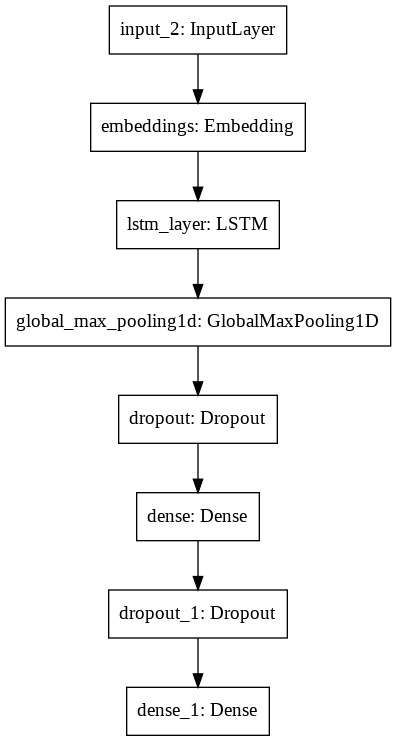

In [97]:
tf.keras.utils.plot_model(glovelstm_model)

In [99]:
print('Training progress:')
history = glovelstm_model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/2
3990/3990 [==============================] - 412s 103ms/step - loss: 0.1948 - accuracy: 0.9309 - val_loss: 0.1489 - val_accuracy: 0.9440
Epoch 2/2
3990/3990 [==============================] - 429s 108ms/step - loss: 0.1453 - accuracy: 0.9481 - val_loss: 0.1407 - val_accuracy: 0.9473


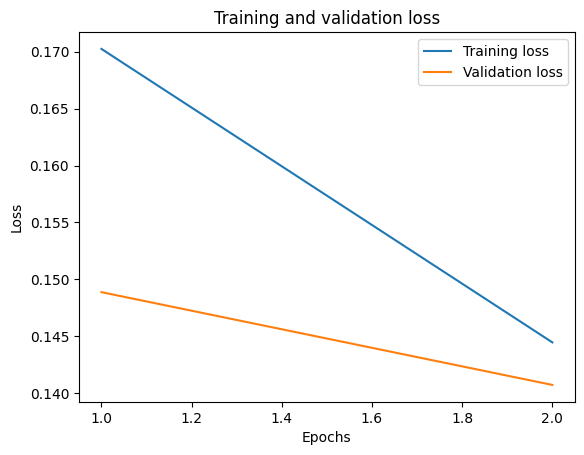

In [101]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

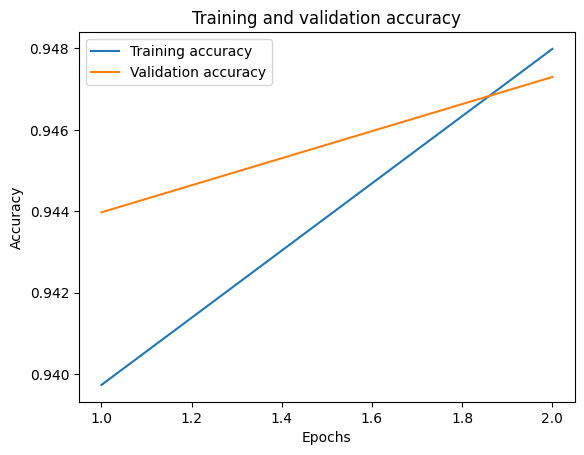

In [103]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [104]:
#save model
glovelstm_model.save('/content/drive/MyDrive/lime-lite_files/')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/lime-lite_files/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/lime-lite_files/assets


In [130]:
def glovelstm_classifier(texts):
  my_seq = tokenizer.texts_to_sequences([texts])
  my_data = pad_sequences(my_seq, padding = 'post', maxlen = 200)
  preds = glovelstm_model.predict(my_data)

  return preds
  
print(glovelstm_classifier("my model fucking sucks"))
print(glovelstm_classifier("my model is great"))

[[0.9922972]]
[[0.01875556]]


In [116]:
preds = glovelstm_model.predict(x_train[1:20])

print(preds)

[[0.06658843]
 [0.00037289]
 [0.01309037]
 [0.08799621]
 [0.07156697]
 [0.00081864]
 [0.01642928]
 [0.00032786]
 [0.32048514]
 [0.0114083 ]
 [0.00340778]
 [0.00053841]
 [0.00314069]
 [0.00754404]
 [0.23164207]
 [0.02409413]
 [0.00074261]
 [0.00058717]
 [0.01464728]]


# BERT

In [127]:
import torch.nn.functional as F

In [158]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

bert_tokenizer = AutoTokenizer.from_pretrained("mohsenfayyaz/toxicity-classifier")
bert_model = AutoModelForSequenceClassification.from_pretrained("mohsenfayyaz/toxicity-classifier")

In [160]:
#tokenized_input = bert_tokenizer.encode("This is a sample text to test the tokenizer.")
#output = model( torch.tensor([tokenized_input]) )

def bert_classifier(texts):
  outputs = bert_model(**bert_tokenizer(texts, return_tensors="pt", padding=True))
  probas = F.softmax(outputs.logits).detach().numpy()
  return probas

print(bert_classifier("my model fucking sucks"))
print(bert_classifier("my model is great"))

[[2.5030703e-04 9.9974972e-01]]
[[9.9974805e-01 2.5195169e-04]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


# LIME-Lite

In [65]:
# Explainer - LIME

#f = classifier, N = number of samples, pi = similarity kernel, K = length of explanation (used for K-Lasso)
#x = instance, x' = interpretable version (bag of words), z' = subspace of x, Z = perturbed X, w = weights 

class LIME_Lite:
    
    #required f - classifier
    #required pi - similarity kernel
    #required N - number of samples
    #required K - length of explanation K
    
    def __init__(self, N, K=10):
        self.N = N
        self.K = K
        #sigma = 25
        #self.kernel_fn = lambda D: np.sqrt(np.exp(-(D**2) / sigma ** 2))

    def similarity_kernel(self, x, z):
        
        # cosine similarity
        cos_distance = sklearn.metrics.pairwise.cosine_distances(x, z)[0]*100
        
        # distance kernel
        sigma = 25
        kernalized_distance = lambda D: np.sqrt(np.exp(-(D**2)/sigma**2))
        kernalized_D = kernalized_distance(cos_distance)
        
        return kernalized_D

    def heuristic_sampling(sample, type, distance=.1):

        #regular consine similarity
        def distance(type, x, y):
          #if type == "cosine":
          return sklearn.metrics.pairwise.cosine_distances(x, y)[0]*100

          #GloVe+ consine similarity for testing if using glove embeddings can help with the GloVe+LSTM model
          #if type == "soft":
            #cos_distance = sklearn.metrics.pairwise.cosine_distances(x, z)[0]*100

          #BERT embeddings 
          #https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b 
          #(4th layer)
          # if type = "bert"
          #for future work to explore (extract certain layers of bert, early stopping of bert for filtering and full bert for relabeling)
          
        log("start heuristic sampling")
        start = time.time()

        #compute similarity matrix for nxn for samples
        #so we don't have to compute it again
        n_size = len(n)
        distance_matrix = np.zeros((n_size, n_size))
          
        #filter current number of samples by distances

        for i in range(n):
          #j starts on next datapoint so we don't refilter the same sample
          for j in range(i+1, n):
            return matrix
        
        #gets all indices 
        for i in range(n):
            for j in range(i+1, n):


        end = time.time()

        log(end - start)

        return new_sample, time_elapsed


    
    def explain_instance(self, x, label, classifier):   
        
        #x, #x', #z, #z'
        
        # x -> x'
        #print(x)
        
        # Z <- {}
        
        #gets all the features
        features = x.nonzero()[1]
        vals = np.array(x[x.nonzero()])[0]
        log(["values", vals])

        #gets a sample
        num_features = len(features)
        sample = np.random.randint(1, num_features, self.N - 1)
        log(["sample", sample])
        
        #create sample x features
        data = np.zeros((self.N, num_features))
        inverse_data = np.zeros((self.N, num_features))     
        
        #setup
        data[0] = np.ones(num_features)
        inverse_data[0] = vals
        features_range = range(len(features))
        
        # z' = sample around (x')
        #for i in range(N):
        for i, s in enumerate(sample, start=1):
            #drawing non zero elements of x' uniformly at random
            #(where the number of such draws is also uniformly sampled)
            
            #random permutation with features_range
            active = np.random.choice(features_range, s, replace=False) 
            
            data[i, active] = 1
            
            for j in active:
                inverse_data[i, j] = 1
                
        log(["data", data])
        log(["inverse_data", inverse_data])
        
        #converting back to sparse matrix
        z_s = sp.sparse.lil_matrix((inverse_data.shape[0], x.shape[1]))
        z_s[:, features] = inverse_data
        z_s = sp.sparse.csr_matrix(z_s)
        log(["sparse_inverse", z_s.getnnz()])
        log(["sparse_inverse", z_s])
        
        
        # Z = Z union <z'_i f(z_i), pi_x(z_i)>
        
        #f(z) - getting the labels
        labels = classifier.predict_proba(z_s)
        
        #pi_x(z_i) - getting the distances
        #weights the data based on distance
        orig_x = z_s[0]
        weights = self.similarity_kernel(orig_x, z_s)
        log(["distances:", weights])        
        weighted_data = data * weights[:, np.newaxis]
        
        #label = 0 | 1
        log(["labels", labels])
        print(labels[:, label])
        mean = np.mean(labels[:, label])
        shifted_labels = labels[:, label] - mean
        log(['mean', mean])
        
        weighted_labels = shifted_labels * weights
        
        log(["weighted_data", weighted_data])
        log(["weighted_labels", weighted_labels])

        
        used_features = range(weighted_data.shape[1])
        log(["used_features", len(used_features)])
        
        #K-Lasso
        #w = K-Lasso(Z,K) with z'_i as features, f(z) as target
        #selecting K features with Lasso (using the regularization path [9 - Least Angle Regression]) 
        
        nonzero = used_features
        
        alpha = 1
        alphas, _, coefs = sklearn.linear_model.lars_path(weighted_data, weighted_labels, method='lasso')
        
        #select K
        for i in range(len(coefs.T) - 1, 0, -1):
            nonzero = coefs.T[i].nonzero()[0]
            if len(nonzero) <= self.K:
                chosen_coefs = coefs.T[i]
                alpha = alphas[i]
                break
                
        used_features = nonzero

        #learning the weights via least squares        
        #fitting a linear sparse model with target labels of f(z)
        local_model = linear_model.Ridge(alpha=0, fit_intercept=False)
        local_model.fit(weighted_data[:, used_features], weighted_labels)
        
        original_label = labels[0, label]
        local_prediction = local_model.predict(data[0, used_features].reshape(1, -1)) + mean
        log(["True Label vs Local Model Prediction: ", original_label, local_prediction])
        
        #print(zip(used_features, local_model.coef_), key=lambda x:np.abs(x[1]))
        
        #mapping feature indices back to features
        vocab_features = []
        
        for feature in used_features:
            vocab_features.append(features[feature])
            
        #print(used_features)
        explanations = sorted(zip(vocab_features, local_model.coef_), key=lambda x:np.abs(x[1]), reverse=True)
        #mapped_explanations = map(lambda x: 
                                  
        log(["raw explanation:", explanations])
        
        #x => x' => z' => z
        #mapping features back to vocab
        for explanation in explanations:
            print(["explanation:", inverse_vocabulary[explanation[0]], explanation[1]])
            
        return explanations, mean


In [134]:
#def distance_method(s1, s2):


#https://medium.com/@adriensieg/text-similarities-da019229c894
def cosine_distance_wordembedding_method(s1, s2, embeddings):

  tokenizer.fit_on_texts(texts)
  my_seq = tokenizer.texts_to_sequences([s1, s2])
  #my_data = pad_sequences(my_seq, padding = 'post', maxlen = 200)

  #sequences = tokenizer.texts_to_sequences(texts)
  #word_index = tokenizer.word_index
  
  import scipy
  vector_1 = np.mean([model[word] for word in my_seq(s1)],axis=0)
  vector_2 = np.mean([model[word] for word in my_seq(s2)],axis=0)
  cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
  print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')

  

In [135]:
s1 = "The President greets the press in Chicago"
s2 = "Obama speaks to the Media in Illinois"

#similarity_testers = vectorizer.transform([s1, s2])
#print(similarity_testers)

cosine_distance_wordembedding_method(s1, s2, embeddings_index)

TypeError: ignored

# Evaluations

# Partition by Feature Space

In [195]:
#partition dataset by feature range
def dataset_partition(dataset):
    #criteria by feature size
    criteria = [2, 5, 10, 15, 20, 25, 30, 40]
    vectorizer = CountVectorizer(lowercase=False, binary=True)
    vectors = vectorizer.fit_transform(dataset)
    
    partitions = [ [] for _ in range(len(criteria)) ]

    for i in range(len(dataset)):

      features = vectors[i].nonzero()[1]
      
      for j in range(len(criteria)):
        if len(features) == criteria[j]:
            partitions[j].append(i)

    return partitions

#dataset['test']

partitions = dataset_partition(test_data)

In [204]:
#number of samples in each feature range
print([len(partition) for partition in partitions])

[611, 2014, 1318, 1191, 1085, 1003, 850, 649]


# Inference Speed

In [154]:
import time

#test model inference time with varied samples
def test_model_inference(dataset, model):
  start = time.time()
  for i in tqdm_notebook(range(len(dataset))):
    _ = model(dataset[i])
  end = time.time()
  return (end - start)


In [166]:
test_model_inference(test_data[18], linear_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.09984898567199707

In [167]:
test_model_inference(test_data[:10000], linear_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


3.603745937347412

In [165]:
test_model_inference(test_data[18], glovelstm_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


1.9646129608154297

In [156]:
test_model_inference(test_data[:10000], glovelstm_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


619.2726633548737

In [164]:
test_model_inference(test_data[18], bert_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


2.694949150085449

In [168]:
619.17/1.96*2.7

852.9382653061224

# Explanations

In [136]:
def test_explanation(dataset, model, explainer):
  start = timer()
  _ = explainer.model(dataset)
  end = timer()
  return exp

In [ ]:
#test explanation overlap
def test_overlap(exps1, exps2):
  


In [47]:
explainer = LIME_Lite(N=100, K=3)
LIME_explain_fn = LIME_explainer.explain_instance(test_vectors[10], test_labels[10], classifier)

print(LIME_explain_fn)

str_to_predict = "my models fucking sucks"
exp = explainer.explain_instance(str_to_predict, predictor, num_features=20, num_samples=2000)
exp.show_in_notebook(text=str_to_predict)

NameError: ignored

In [178]:
dataset['test']
print(dataset['test'])

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 159571
    })
    test: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 63978
    })
})


# Reference Resources

In [63]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

vocab = vectorizer.vocabulary_
terms = np.array(list(vectorizer.vocabulary_.keys()))
indices = np.array(list(vectorizer.vocabulary_.values()))
inverse_vocabulary = terms[np.argsort(indices)]

In [64]:


bert

test prediction: [[0.99399471 0.00600529]]


In [169]:
DEBUG = False

def log(s):
    if DEBUG:
        print(s)

explainer = LIME_Lite(N=100, K=3)
explain_fn = explainer.explain_instance(test_vectors[10], test_labels[10], classifier)


str_to_predict = "this is fucking crazy"
exp = explainer.explain_instance(str_to_predict, bert_classifier)
exp.show_in_notebook(text=str_to_predict)

bert_predictor(texts)
print(LIME_explain_fn)

[0.99399471 0.97108739 0.88736087 0.93642381 0.96594677 0.99029936
 0.99397109 0.91567948 0.90967543 0.99589496 0.96644115 0.98339875
 0.99611486 0.96820776 0.9626943  0.98755199 0.99601769 0.95757713
 0.97417052 0.92991671 0.89425904 0.98464798 0.90170258 0.97193377
 0.92790661 0.95448707 0.98824049 0.99299443 0.91948376 0.97828663
 0.98920782 0.96327762 0.9765308  0.99335808 0.98960056 0.99427038
 0.98649883 0.95704921 0.97380784 0.98888556 0.99399471 0.90875926
 0.98098857 0.97042413 0.98798311 0.91985425 0.95174551 0.9929608
 0.9431835  0.90842104 0.98909171 0.98261684 0.94566615 0.97533423
 0.9715324  0.96270806 0.97097862 0.95843596 0.99040422 0.98789935
 0.97527437 0.80962541 0.93165471 0.99623509 0.99665864 0.84132556
 0.95670457 0.98472471 0.92764193 0.90936651 0.92073022 0.96711823
 0.98774362 0.99721523 0.9502582  0.96488164 0.93894435 0.9818072
 0.96196812 0.99052807 0.99275787 0.96634501 0.98869245 0.97324269
 0.99065745 0.99049324 0.91666027 0.99551569 0.97689885 0.979850

TypeError: ignored

In [ ]:
#glove-embedding
#word-embedding with BERT and BERT layers
#https://towardsdatascience.com/word-embedding-using-bert-in-python-dd5a86c00342
#https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b
#https://github.com/huggingface/transformers/issues/876

#similarity function
#https://www.machinelearningplus.com/nlp/cosine-similarity/
#https://medium.com/@adriensieg/text-similarities-da019229c894

#distance function - selecting most points that at maximally farthest apart
#https://scicomp.stackexchange.com/questions/20030/selecting-most-scattered-points-from-a-set-of-points

#good LIME tutorials/explanations
#https://santiagof.medium.com/model-interpretability-making-your-model-confesses-surrogate-models-3dbf72bee8e
#https://thenlp.space/blog/lime

#BERT
#https://www.kaggle.com/jgdshkovi/bert-model-twijk-96-77

#GloVe-LSTM
#https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7